In [51]:
import time
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import sklearn.metrics as metrics

In [23]:
# Source: 
# https://www.learnopencv.com/image-classification-using-transfer-learning-in-pytorch/

# Applying Transforms to the Data
image_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
#         transforms.RandomRotation(degrees=15),
#         transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


# Set train and valid directory paths
train_directory = '/home/advo/PycharmProjects/ML_ND3_CapstoneProject/Dataset_small/patches/train'
valid_directory = '/home/advo/PycharmProjects/ML_ND3_CapstoneProject/Dataset_small/patches/valid'
test_directory = '/home/advo/PycharmProjects/ML_ND3_CapstoneProject/Dataset_small/patches/test'
 
# Batch size
bs = 64
 
# Number of classes
num_classes = 2
 
# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}
 
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])
 
# Create iterators for the Data loaded using DataLoader module
train_data = torch.utils.data.DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data = torch.utils.data.DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data = torch.utils.data.DataLoader(data['test'], batch_size=bs, shuffle=True)
 
# Print the train, validation and test set data sizes
print(f"Train size: {train_data_size} \nValidation size: {valid_data_size} \nTest size: {test_data_size}") 

Train size: 151293 
Validation size: 35876 
Test size: 35659


In [35]:
# Load pretrained AlexNet Model
alexnet = torchvision.models.alexnet(pretrained=True)

In [28]:
densenet = torchvision.models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/advo/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100.0%


In [29]:
# Select the model (alexnet/densenet)
model = densenet

In [30]:
# Freeze the parameters for the pretrained part
# Source: https://pytorch.org/docs/master/notes/autograd.html
for param in model.parameters():
    param.requires_grad = False

In [58]:
# Note: both models must be loaded, for this to work
if model == densenet:
    
    # Update the classifier layer, in order to output the required number of classes specific to our problem
    # Note: see model.eval() for details of each layer
    model.classifier = nn.Linear(in_features=2208, out_features=num_classes, bias=True)

else:
    
    # Source: 
    # https://analyticsindiamag.com/implementing-alexnet-using-pytorch-as-a-transfer-learning-model-in-multi-class-classification/
    # Updating the second classifier(reduce the number of outputs, to prevent overfitting)
    alexnet.classifier[4] = nn.Linear(4096,1024)

    # Updating the third and the last classifier that is the output layer of the network
    # Binary classification , thus only 2 output nodes
    alexnet.classifier[6] = nn.Linear(1024, num_classes)

model_name = model.__class__.__name__
    
    

Define loss function: Cross Entropy Loss

Note: Improvement option by adding weight class check

In [38]:
# Source: 
# https://github.com/choosehappy/PytorchDigitalPathology/blob/master/visualization_densenet/train_densenet.ipynb

# we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
# to avoid biasing any particular class
# nclasses = dataset["train"].classsizes.shape[0]
# class_weight=dataset["train"].classsizes
# class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

# print(class_weight) #show final used weights, make sure that they're reasonable before continouing


# criterion = torch.nn.CrossEntropyLoss(weight = class_weight)
criterion = nn.CrossEntropyLoss()


Define optimizer: Adam

In [39]:
# Source: 
# https://github.com/choosehappy/PytorchDigitalPathology/blob/master/visualization_densenet/train_densenet.ipynb

# adam is going to be the most robust, though perhaps not the best performing, typically a good place to start
optimizer = optim.Adam(model.parameters()) 

In [ ]:
# for epoch in range(10):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(train_data, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data[0].to(device), data[1].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         output = alexnet(inputs)
#         loss = criterion(output, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training of AlexNet')

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"You are running on the following device: {device}")

You are running on the following device: cpu


**Print model and optimizer parameters before training**

In [42]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
features.conv0.weight 	 torch.Size([96, 3, 7, 7])
features.norm0.weight 	 torch.Size([96])
features.norm0.bias 	 torch.Size([96])
features.norm0.running_mean 	 torch.Size([96])
features.norm0.running_var 	 torch.Size([96])
features.norm0.num_batches_tracked 	 torch.Size([])
features.denseblock1.denselayer1.norm1.weight 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.bias 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.running_mean 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.running_var 	 torch.Size([96])
features.denseblock1.denselayer1.norm1.num_batches_tracked 	 torch.Size([])
features.denseblock1.denselayer1.conv1.weight 	 torch.Size([192, 96, 1, 1])
features.denseblock1.denselayer1.norm2.weight 	 torch.Size([192])
features.denseblock1.denselayer1.norm2.bias 	 torch.Size([192])
features.denseblock1.denselayer1.norm2.running_mean 	 torch.Size([192])
features.denseblock1.denselayer1.norm2.running_var 	 torch.Size([192])
features.de

features.denseblock2.denselayer11.norm1.bias 	 torch.Size([672])
features.denseblock2.denselayer11.norm1.running_mean 	 torch.Size([672])
features.denseblock2.denselayer11.norm1.running_var 	 torch.Size([672])
features.denseblock2.denselayer11.norm1.num_batches_tracked 	 torch.Size([])
features.denseblock2.denselayer11.conv1.weight 	 torch.Size([192, 672, 1, 1])
features.denseblock2.denselayer11.norm2.weight 	 torch.Size([192])
features.denseblock2.denselayer11.norm2.bias 	 torch.Size([192])
features.denseblock2.denselayer11.norm2.running_mean 	 torch.Size([192])
features.denseblock2.denselayer11.norm2.running_var 	 torch.Size([192])
features.denseblock2.denselayer11.norm2.num_batches_tracked 	 torch.Size([])
features.denseblock2.denselayer11.conv2.weight 	 torch.Size([48, 192, 3, 3])
features.denseblock2.denselayer12.norm1.weight 	 torch.Size([720])
features.denseblock2.denselayer12.norm1.bias 	 torch.Size([720])
features.denseblock2.denselayer12.norm1.running_mean 	 torch.Size([720])

features.denseblock3.denselayer14.conv1.weight 	 torch.Size([192, 1008, 1, 1])
features.denseblock3.denselayer14.norm2.weight 	 torch.Size([192])
features.denseblock3.denselayer14.norm2.bias 	 torch.Size([192])
features.denseblock3.denselayer14.norm2.running_mean 	 torch.Size([192])
features.denseblock3.denselayer14.norm2.running_var 	 torch.Size([192])
features.denseblock3.denselayer14.norm2.num_batches_tracked 	 torch.Size([])
features.denseblock3.denselayer14.conv2.weight 	 torch.Size([48, 192, 3, 3])
features.denseblock3.denselayer15.norm1.weight 	 torch.Size([1056])
features.denseblock3.denselayer15.norm1.bias 	 torch.Size([1056])
features.denseblock3.denselayer15.norm1.running_mean 	 torch.Size([1056])
features.denseblock3.denselayer15.norm1.running_var 	 torch.Size([1056])
features.denseblock3.denselayer15.norm1.num_batches_tracked 	 torch.Size([])
features.denseblock3.denselayer15.conv1.weight 	 torch.Size([192, 1056, 1, 1])
features.denseblock3.denselayer15.norm2.weight 	 torc

features.denseblock3.denselayer31.conv2.weight 	 torch.Size([48, 192, 3, 3])
features.denseblock3.denselayer32.norm1.weight 	 torch.Size([1872])
features.denseblock3.denselayer32.norm1.bias 	 torch.Size([1872])
features.denseblock3.denselayer32.norm1.running_mean 	 torch.Size([1872])
features.denseblock3.denselayer32.norm1.running_var 	 torch.Size([1872])
features.denseblock3.denselayer32.norm1.num_batches_tracked 	 torch.Size([])
features.denseblock3.denselayer32.conv1.weight 	 torch.Size([192, 1872, 1, 1])
features.denseblock3.denselayer32.norm2.weight 	 torch.Size([192])
features.denseblock3.denselayer32.norm2.bias 	 torch.Size([192])
features.denseblock3.denselayer32.norm2.running_mean 	 torch.Size([192])
features.denseblock3.denselayer32.norm2.running_var 	 torch.Size([192])
features.denseblock3.denselayer32.norm2.num_batches_tracked 	 torch.Size([])
features.denseblock3.denselayer32.conv2.weight 	 torch.Size([48, 192, 3, 3])
features.denseblock3.denselayer33.norm1.weight 	 torch.

features.denseblock4.denselayer9.conv2.weight 	 torch.Size([48, 192, 3, 3])
features.denseblock4.denselayer10.norm1.weight 	 torch.Size([1488])
features.denseblock4.denselayer10.norm1.bias 	 torch.Size([1488])
features.denseblock4.denselayer10.norm1.running_mean 	 torch.Size([1488])
features.denseblock4.denselayer10.norm1.running_var 	 torch.Size([1488])
features.denseblock4.denselayer10.norm1.num_batches_tracked 	 torch.Size([])
features.denseblock4.denselayer10.conv1.weight 	 torch.Size([192, 1488, 1, 1])
features.denseblock4.denselayer10.norm2.weight 	 torch.Size([192])
features.denseblock4.denselayer10.norm2.bias 	 torch.Size([192])
features.denseblock4.denselayer10.norm2.running_mean 	 torch.Size([192])
features.denseblock4.denselayer10.norm2.running_var 	 torch.Size([192])
features.denseblock4.denselayer10.norm2.num_batches_tracked 	 torch.Size([])
features.denseblock4.denselayer10.conv2.weight 	 torch.Size([48, 192, 3, 3])
features.denseblock4.denselayer11.norm1.weight 	 torch.S

In [63]:
# history = []
# # Initialize the variable storing accuracy and loss (with max/min values)
# history.append([1.0, 1.0, 0.0, 0.0])
# best_loss_on_val = np.Infinity

epochs = 1
for epoch in range(epochs):
    epoch_start = time.time()
#     print("Epoch: {}/{}".format(epoch, epochs))
     
    # Set to training mode
    model.train()
     
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
     
    valid_loss = 0.0
    valid_acc = 0.0
 
    # Iterate through all batches of training data
    for i, (inputs, labels) in enumerate(train_data):
 
        inputs = inputs.to(device)
        labels = labels.to(device)
         
        # Clean existing gradients
        optimizer.zero_grad()
         
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
        
#         print("predictions")
#         print(outputs)
         
        # Compute loss
        loss = criterion(outputs, labels)
         
        # Backpropagate the gradients
        loss.backward()
         
        # Update the parameters
        optimizer.step()
         
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
         
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
#         print("ret")
#         print(ret)
#         print("predictions")
#         print(predictions)

        correct_counts = predictions.eq(labels.data.view_as(predictions))
#         print("correct counts")
#         print(correct_counts)
         
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
#         print("acc")
#         print(acc)
         
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)

         
#         print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        # Break "train_data batch" for loop
#         break
    
        

    # Validation is carried out in each epoch immediately after the training loop
    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        # Iterate through all batches of validation data
        for j, (inputs, labels) in enumerate(valid_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)


#             print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

            # Break "valid_data batch" for loop
#             break

    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/float(train_data_size)

    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/valid_data_size
    avg_valid_acc = valid_acc/float(valid_data_size)

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    epoch_end = time.time()

    print(f"Model: {model_name}")
    print("Epoch : {:03d} \nTraining: Loss: {:.4f}, Accuracy: {:.4f}%, \nValidation : Loss : {:.4f}, Accuracy: {:.4f}%, \n Time (train+val): {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

    
    # Source: https://github.com/choosehappy/PytorchDigitalPathology/blob/master/classification_lymphoma_densenet/train_densenet.ipynb
    # If current loss is the best we've seen, save model state with all variables
    # necessary for recreation
    if avg_valid_loss < best_loss_on_val:
        best_loss_on_val = avg_valid_loss
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optimizer.state_dict(),
         'best_loss_on_val': best_loss_on_val}

        torch.save(state, f"{model_name}_best_model.pth")
        print(f"Saved model {model_name} with loss {avg_valid_loss}")
    else:
        print("")
    
    # Stop "epoch" for
#     break

Model: DenseNet
Epoch : 000 
Training: Loss: 0.6767, Accuracy: 57.2769%, 
Validation : Loss : 5.6540, Accuracy: 35.4053%, 
 Time (train+val): 31074.5262s
  **
Saved model DenseNet with loss 5.654006976881399


Model: DenseNet
Epoch : 000 
Training: Loss: 0.6769, Accuracy: 57.1705%, 
Validation : Loss : 5.7904, Accuracy: 35.1516%, 
 Time (train+val): 33245.9189s
  **
Saved model DenseNet with loss 5.790416442187604


**Plot the accuracy and loss**

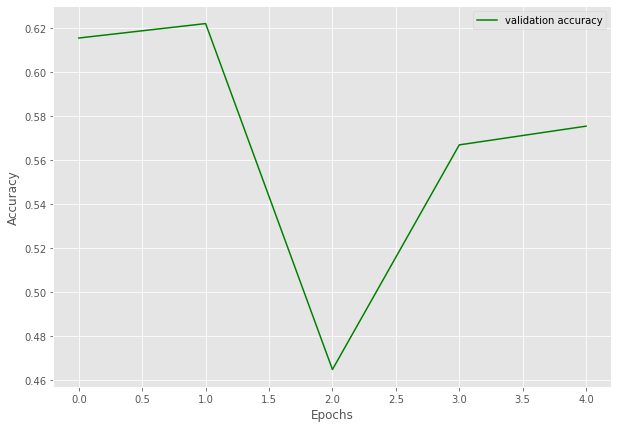

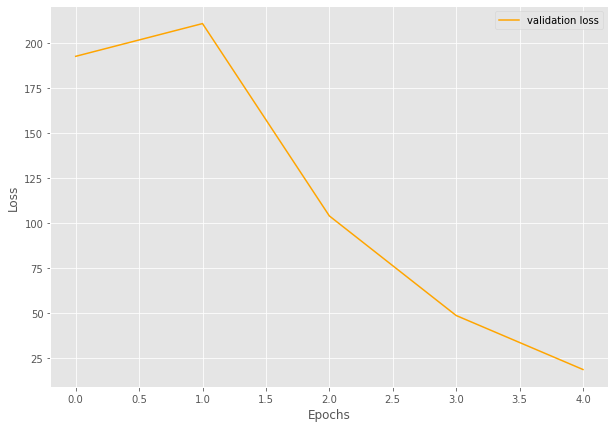

In [18]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(range(len(history_loaded)), [x[3] for x in history_loaded] , color='green', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('outputs/initial_validation_accuracy.png')
plt.show()
 
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(range(len(history_loaded)), [x[1] for x in history_loaded], color='orange', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('outputs/initial_training_loss.png')
plt.show()

**Print model and optimizer parameters after training**

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in alexnet.state_dict():
    print(param_tensor, "\t", alexnet.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

**Save the model**

In [ ]:
# Source:
# https://debuggercafe.com/effective-model-saving-and-resuming-training-in-pytorch/
# save model checkpoint
torch.save({
            'epoch': epochs,
            'model_state_dict': alexnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'outputs/alexnet_trained.pth')

**Initialize the model before loading the previously saved one**

In [4]:
# Initialize the model
alexnet_loaded = torchvision.models.alexnet(pretrained=True)
# Initialize optimizer  before loading optimizer state_dict
optimizer_loaded = optim.Adam(alexnet_loaded.parameters()) 

# Updating the second classifier
alexnet_loaded.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 10 output nodes if we are going to get 10 class labels through our model.
# AdVo: i will have a binary classification , thus only 2 output nodes
alexnet_loaded.classifier[6] = nn.Linear(1024, num_classes)

**Load the saved model**

In [5]:
# load the model checkpoint
checkpoint = torch.load('outputs/alexnet_trained.pth')

# load model weights state_dict
alexnet_loaded.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')

# load trained optimizer state_dict
optimizer_loaded.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')

epochs = checkpoint['epoch']

# load the criterion
criterion_loaded = checkpoint['loss']
print('Trained model loss function loaded...')

print(f"Previously trained for {epochs} number of epochs...")


Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Trained model loss function loaded...
Previously trained for 3 number of epochs...


**Print loaded model and optimizer parameters**

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in alexnet_loaded.state_dict():
    print(param_tensor, "\t", alexnet_loaded.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer_loaded.state_dict():
    print(var_name, "\t", optimizer_loaded.state_dict()[var_name])

**Initialize parameters for second phase of training (optional)**

In [6]:
# learning parameters
batch_size = 64
new_epochs = 5
# lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train for more epochs
epochs = new_epochs
print(f"Train for {epochs} more epochs...")

Train for 5 more epochs...


In [15]:
history_loaded = []
for epoch in range(epochs):
    epoch_start = time.time()
#     print("Epoch: {}/{}".format(epoch, epochs))
     
    # Set to training mode
    alexnet_loaded.train()
     
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
     
    valid_loss = 0.0
    valid_acc = 0.0
 
    # Iterate through all batches of training data
    for i, (inputs, labels) in enumerate(train_data):
 
        inputs = inputs.to(device)
        labels = labels.to(device)
         
        # Clean existing gradients
        optimizer_loaded.zero_grad()
         
        # Forward pass - compute outputs on input data using the model
        outputs = alexnet_loaded(inputs)
        
#         print("predictions")
#         print(outputs)
         
        # Compute loss
        loss = criterion_loaded(outputs, labels)
         
        # Backpropagate the gradients
        loss.backward()
         
        # Update the parameters
        optimizer_loaded.step()
         
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
         
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
#         print("ret")
#         print(ret)
#         print("predictions")
#         print(predictions)

        correct_counts = predictions.eq(labels.data.view_as(predictions))
#         print("correct counts")
#         print(correct_counts)
         
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
#         print("acc")
#         print(acc)
         
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)

         
#         print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
        

    # Validation is carried out in each epoch immediately after the training loop
    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        alexnet_loaded.eval()

        # Validation loop
        # Iterate through all batches of validation data
        for j, (inputs, labels) in enumerate(valid_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = alexnet_loaded(inputs)

            # Compute loss
            loss = criterion_loaded(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)


#             print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average training loss and training accuracy
    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/float(train_data_size)

    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/valid_data_size
    avg_valid_acc = valid_acc/float(valid_data_size)

    history_loaded.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    epoch_end = time.time()

    print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, \n Time (train+val): {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))


Epoch : 000, Training: Loss: 0.0290, Accuracy: 99.0720%, 
		Validation : Loss : 192.5187, Accuracy: 61.5314%, 
 Time (train+val): 4045.6382s
Epoch : 001, Training: Loss: 0.0275, Accuracy: 99.1176%, 
		Validation : Loss : 210.6774, Accuracy: 62.1864%, 
 Time (train+val): 3821.8940s
Epoch : 002, Training: Loss: 0.0420, Accuracy: 98.6470%, 
		Validation : Loss : 104.0322, Accuracy: 46.4879%, 
 Time (train+val): 3726.6068s
Epoch : 003, Training: Loss: 0.0308, Accuracy: 98.9854%, 
		Validation : Loss : 48.8112, Accuracy: 56.6813%, 
 Time (train+val): 4840.4254s
Epoch : 004, Training: Loss: 0.0338, Accuracy: 98.9233%, 
		Validation : Loss : 18.8629, Accuracy: 57.5315%, 
 Time (train+val): 4220.9801s


**Evaluate model based on test dataset**

In [14]:
test_start = time.time()

# Loss and Accuracy within the epoch
test_loss = 0.0
test_acc = 0.0

# Validation is carried out in each epoch immediately after the training loop
# Validation - No gradient tracking needed
with torch.no_grad():

    # Set to evaluation mode
    alexnet_loaded.eval()

    # Validation loop
    # Iterate through all batches of validation data
    for j, (inputs, labels) in enumerate(test_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass - compute outputs on input data using the model
        outputs = alexnet_loaded(inputs)

        # Compute loss
        loss = criterion_loaded(outputs, labels)

        # Compute the total loss for the batch and add it to valid_loss
        test_loss += loss.item() * inputs.size(0)

        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to valid_acc
        test_acc += acc.item() * inputs.size(0)

#             print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))


# Find average testing loss and accuracy
avg_test_loss = test_loss/test_data_size
avg_test_acc = test_acc/float(test_data_size)

# history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

test_end = time.time()

print("Test : Loss : {:.4f}, Accuracy: {:.4f}%, \n Time : {:.4f}s".format(avg_test_loss, avg_test_acc*100, test_end-test_start))

Test : Loss : 72.5857, Accuracy: 66.7013%, 
 Time : 380.4901s


In [ ]:
y_pred_list = []
y_test = []

alexnet.eval()
with torch.no_grad():
    for X_batch in test_data:
#         X_batch = X_batch.to(device)
        y_test_pred = alexnet(X_batch[0])
#         y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        labels = X_batch[1]
        y_test.append(labels) 
#         print(type(X_batch[0]))
#         break
        
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_test = [a.squeeze().tolist() for a in y_test]

In [ ]:
len(y_test[0])

In [ ]:
print(y_pred_list[0])

In [ ]:
metrics.confusion_matrix(y_test, y_pred_list)